# Preprocesamento e evaluación de clasificadores

#### Abraham Trashorras Rivas

#### Instalacion de librerias menos comúns

In [346]:
%pip install MissForest
%pip install lightgbm
%pip install seaborn
%pip install -U scikit-learn 
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Carga de librerías empregadas

In [347]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from missforest.missforest import MissForest
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report, auc, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#### Definición de variables globais

In [348]:
GLOBAL_RANDOM_STATE = 42

Vamos a cargar o conxunto de datos e ver a súa estrutura inicial

In [349]:
df = pd.read_csv('datos_accidentes_cerebrovasculares.csv', header=0, sep=',')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


A columna id en primeira instancia non creo que nos aporte ningun valor ao estudo xa que so identifica a orixe de cada dato. Tamen debemos cambiar o tipo de datos de idade de float a int.

Vamos a comprobar as columnas con elementos NaN

In [350]:
df.isnull().sum()[df.isnull().sum() != 0]

bmi    201
dtype: int64

A columna bmi presenta datos NaN, teremos que tratalos. Vamos a revisar as columnas con clases.

In [351]:
print(f"ever_married: {X_forest_imputed['ever_married'].unique()}" )
print(f"gender: {X_forest_imputed['gender'].unique()}")
print(f"work_type: {X_forest_imputed['work_type'].unique()}")
print(f"Residence_type: {X_forest_imputed['Residence_type'].unique()}")
print(f"smoking_status: {df['smoking_status'].unique()}")

ever_married: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']
gender: ['Female', 'Male', 'Other']
Categories (3, object): ['Female', 'Male', 'Other']
work_type: ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Categories (5, object): ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']
Residence_type: ['Urban', 'Rural']
Categories (2, object): ['Rural', 'Urban']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


A columna smoking_status ten un valor Unknown que trataremos como NaN.

In [352]:
df[(df['smoking_status'].isin(['formerly smoked', 'smokes'])) & (df['work_type'] == 'children')]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1389,68235,Male,12.0,0,0,No,children,Rural,86.00,20.1,formerly smoked,0
1512,4833,Female,12.0,0,0,No,children,Rural,207.45,25.4,smokes,0
1686,37698,Female,15.0,0,0,No,children,Urban,87.96,21.5,formerly smoked,0
1774,57109,Female,12.0,0,0,No,children,Rural,81.66,23.5,formerly smoked,0
1833,34958,Male,14.0,0,0,No,children,Urban,92.86,20.7,formerly smoked,0
1866,25305,Male,10.0,0,0,No,children,Rural,99.87,NaN,formerly smoked,0
2013,64128,Male,10.0,0,0,No,children,Urban,63.08,20.5,smokes,0
2450,54253,Male,11.0,0,0,No,children,Urban,144.08,16.2,formerly smoked,0
2526,62454,Female,12.0,0,0,No,children,Urban,63.98,21.2,formerly smoked,0
3044,17198,Female,10.0,0,0,No,children,Rural,83.37,17.8,formerly smoked,0


Curiosamente hai "crianzas" que fuman ou fumaron, supoño que inclúen neste grupo persoas de 16 a 18 anos inclusive.

## PREPROCESADO

### Tipado de datos
Antes de modificar os elementos vamos a formatear algunhas das columnas. Primeiro a columna "age" que precisa o cambio de float a int e despois convertiremos "gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type" e "smoking_status" en categorias.

Ademais, para as categorías mapeamos os valores binaros en valores textuales máis simples de comprender

In [353]:
df['age'] = df['age'].astype('int64')

df['hypertension'].mask(df['hypertension'] == 0, 'No', inplace=True)
df['hypertension'].mask(df['hypertension'] == 1, 'Yes', inplace=True)
df['hypertension'] = df['hypertension'].astype('category')

df['heart_disease'].mask(df['heart_disease'] == 0, 'No', inplace=True)
df['heart_disease'].mask(df['heart_disease'] == 1, 'Yes', inplace=True)
df['heart_disease'] = df['heart_disease'].astype('category')

df['gender'] = df['gender'].astype('category')
df['ever_married'] = df['ever_married'].astype('category')
df['work_type'] = df['work_type'].astype('category')
df['Residence_type'] = df['Residence_type'].astype('category')
df['smoking_status'] = df['smoking_status'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   int64   
 3   hypertension       5110 non-null   category
 4   heart_disease      5110 non-null   category
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   bmi                4909 non-null   float64 
 10  smoking_status     5110 non-null   category
 11  stroke             5110 non-null   int64   
dtypes: category(7), float64(2), int64(3)
memory usage: 235.7 KB


C:\Users\acull\AppData\Local\Temp\ipykernel_25404\1358651851.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['hypertension'].mask(df['hypertension'] == 0, 'No', inplace=True)
C:\Users\acull\AppData\Local\Temp\ipykernel_25404\1358651851.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'No' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df['heart_disease'].mask(df['heart_disease'] == 0, 'No', inplace=True)


In [354]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,No,No,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,No,No,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Gestion de datos ausentes

#### smoking_satus
smoking_status ten datos coa tag "Unknown" que trataremos como NaN, polo que vamos a formatealos.

In [355]:
df['smoking_status'].mask(df['smoking_status'] == "Unknown", np.NaN, inplace=True)

In [356]:
df.isnull().sum()[df.isnull().sum() != 0]

bmi                201
smoking_status    1544
dtype: int64

In [357]:
porcentaxe_nan = df.isnull().sum().smoking_status / df.shape[0] * 100
print(f"'smoking_status' ten un porcentaxe de valores NaN do {porcentaxe_nan:.2f}%")

'smoking_status' ten un porcentaxe de valores NaN do 30.22%


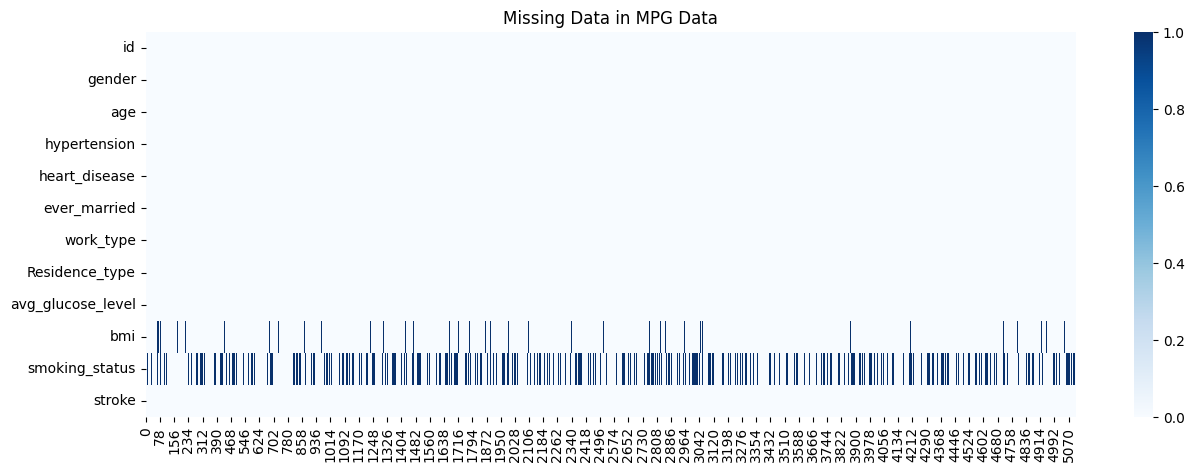

In [358]:
plt.subplots(figsize=(15,5))  
sns.heatmap(df.isnull().transpose(), cmap = 'Blues')
plt.title("Missing Data in MPG Data")
plt.show()

"bmi" é de tipo float mentres que "smoking_status" é de tipo category, vamos a abordalos un a un empregando distintos mecanismos.
Vamos a crear un SimpleImputer cos métodos mice e most_frequent (a moda) para o df "df_classic" que despois expandiremos

#### SimpleImputer

In [359]:
df_classic = df.copy()

In [360]:
si = SimpleImputer(strategy='mean')
df_classic['bmi'] = si.fit_transform(df_classic['bmi'].values.reshape(-1,1))

# Redondeamos a 2 decimales xa que o metodo da media crea 8
df_classic['bmi'] = df_classic['bmi'].round(2)
df_classic.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,No,Yes,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61,No,No,Yes,Self-employed,Rural,202.21,28.89,never smoked,1
2,31112,Male,80,No,Yes,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49,No,No,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79,Yes,No,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [361]:
si = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)
imputed_data = si.fit_transform(df_classic['smoking_status'].values.reshape(-1, 1))
df_classic['smoking_status'] = imputed_data.ravel() 
df_classic['smoking_status'] = df_classic['smoking_status'].astype('category')
df_classic.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,No,Yes,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61,No,No,Yes,Self-employed,Rural,202.21,28.89,never smoked,1
2,31112,Male,80,No,Yes,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49,No,No,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79,Yes,No,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [362]:
df_classic.isnull().sum()[df_classic.isnull().sum() != 0]

Series([], dtype: int64)

## Seleccion de variables

Como tenemos muchas varables categoricas, vamos a utilizar one-hot encoding para aplicar los metodos de selección

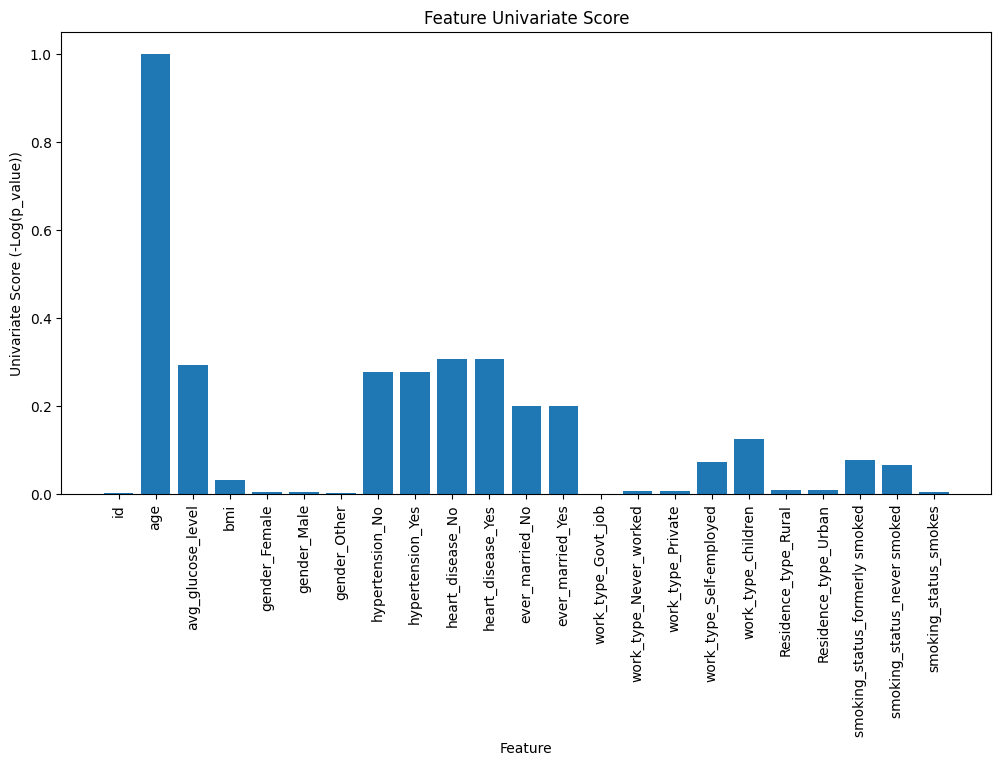

In [363]:
X_classic = df_classic.drop('stroke', axis=1)
y_classic = df_classic['stroke']

numeric_columns = X_classic.select_dtypes(include=['int', 'float']).columns
categorical_columns = X_classic.select_dtypes(include=['category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(X_classic, y_classic)


onehot_features = pipeline.named_steps['preprocessor'].named_transformers_['cat']
onehot_columns = onehot_features.get_feature_names_out(categorical_columns)
all_feature_names = np.concatenate([numeric_columns, onehot_columns])


selector = SelectKBest(f_classif, k='all')
X_processed = pipeline.transform(X_classic)
selector.fit(X_processed, y_classic)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()


plt.figure(figsize=(12, 6))
plt.bar(range(len(scores)), scores, tick_label=all_feature_names)
plt.xticks(rotation=90)
plt.title("Feature Univariate Score")
plt.xlabel("Feature")
plt.ylabel("Univariate Score (-Log(p_value))")
plt.show()

Aquí quería comparar a selección de variables empregando un modelo de regresión, pero non obtiven resultados diferentes

In [364]:
X_train_classic, X_test_classic, y_train_classic, y_test_classic = train_test_split(
    X_classic, y_classic, test_size=0.2, random_state=GLOBAL_RANDOM_STATE, stratify=y_classic)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train_classic)
X_test_processed = preprocessing_pipeline.transform(X_test_classic)

clf_selected = make_pipeline(
    SelectKBest(f_classif, k=4),
    MinMaxScaler(),
    LinearSVC()
)
clf_selected.fit(X_train_processed, y_train_classic)
print(
    "Classification accuracy after univariate feature selection: {:.8f}".format(
        clf_selected.score(X_test_processed, y_test_classic)
    )
)


clf = make_pipeline(
    MinMaxScaler(),
    LinearSVC()
)
clf.fit(X_train_processed, y_train_classic)
print(
    "Classification accuracy without selecting features: {:.8f}".format(
        clf.score(X_test_processed, y_test_classic)
    )
)

Classification accuracy after univariate feature selection: 0.95107632
Classification accuracy without selecting features: 0.95107632


c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### Conclusions

As columnas id, xénero, e residencia non parecen proveer de datos relevantes. A columna bmi tampouco introduce moita información pero vou a mantela. Como a columna smoking_status tiña moitos valores baleiros, vouna eliminar en df_classic_nosmoking para estudar se afecta aos resultados

In [365]:
df_classic = df_classic.drop(columns=['id', 'gender', 'Residence_type'])
df_classic.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,67,No,Yes,Yes,Private,228.69,36.60,formerly smoked,1
1,61,No,No,Yes,Self-employed,202.21,28.89,never smoked,1
2,80,No,Yes,Yes,Private,105.92,32.50,never smoked,1
3,49,No,No,Yes,Private,171.23,34.40,smokes,1
4,79,Yes,No,Yes,Self-employed,174.12,24.00,never smoked,1


In [366]:
df_classic_nosmoking = df_classic.drop(columns=['smoking_status'])
df_classic_nosmoking.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,stroke
0,67,No,Yes,Yes,Private,228.69,36.60,1
1,61,No,No,Yes,Self-employed,202.21,28.89,1
2,80,No,Yes,Yes,Private,105.92,32.50,1
3,49,No,No,Yes,Private,171.23,34.40,1
4,79,Yes,No,Yes,Self-employed,174.12,24.00,1


## Normalización

Vou a normalizar as columnas bmi e avg_glucose_level

In [367]:
scaler = MinMaxScaler(feature_range=(0, 1))

df_classic['bmi'] = scaler.fit_transform(df_classic['bmi'].values.reshape(-1,1))
df_classic['avg_glucose_level'] = scaler.fit_transform(df_classic['avg_glucose_level'].values.reshape(-1,1))
df_classic.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,67,No,Yes,Yes,Private,0.801265,0.301260,formerly smoked,1
1,61,No,No,Yes,Self-employed,0.679023,0.212944,never smoked,1
2,80,No,Yes,Yes,Private,0.234512,0.254296,never smoked,1
3,49,No,No,Yes,Private,0.536008,0.276060,smokes,1
4,79,Yes,No,Yes,Self-employed,0.549349,0.156930,never smoked,1


In [368]:
df_classic_nosmoking['bmi'] = scaler.fit_transform(df_classic_nosmoking['bmi'].values.reshape(-1,1))
df_classic_nosmoking['avg_glucose_level'] = scaler.fit_transform(df_classic_nosmoking['avg_glucose_level'].values.reshape(-1,1))
df_classic_nosmoking.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,stroke
0,67,No,Yes,Yes,Private,0.801265,0.301260,1
1,61,No,No,Yes,Self-employed,0.679023,0.212944,1
2,80,No,Yes,Yes,Private,0.234512,0.254296,1
3,49,No,No,Yes,Private,0.536008,0.276060,1
4,79,Yes,No,Yes,Self-employed,0.549349,0.156930,1


## Balanceo

Como veremos a continuación, algunhas das columans como "heart_desease" están desbalanceadas. Non quero modificalas para non introducir un numero enorme de valores artificiais, pero si crearei unha version de "df_classic" chamada "df_classic_upsampled" con up-sample á variable "yes" da columna "stroke" para comprobar os resultados

In [369]:
categorical_columns = df_classic.select_dtypes(include='category').columns

for column in categorical_columns:
    print(df_classic[column].value_counts())

hypertension
No     4612
Yes     498
Name: count, dtype: int64
heart_disease
No     4834
Yes     276
Name: count, dtype: int64
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
smoking_status
never smoked       3436
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [370]:
stroke_yes = df_classic[df_classic['stroke'] == 1]
stroke_no = df_classic[df_classic['stroke'] == 0]

stroke_yes_upsampled = resample(stroke_yes, replace=True, n_samples=len(stroke_no), random_state=GLOBAL_RANDOM_STATE)
df_classic_upsampled = pd.concat([stroke_no, stroke_yes_upsampled])

print(df_classic_upsampled['stroke'].value_counts())

stroke
0    4861
1    4861
Name: count, dtype: int64


## Modelado

#### Primeiro preparamos os dataframes

In [371]:
def preprocess_data(df, target_column='stroke', test_size=0.2, random_state=GLOBAL_RANDOM_STATE):
    # Dividir los datos en características (X) y etiquetas (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Identificar las columnas numéricas y categóricas
    numeric_columns = X.select_dtypes(include=['int', 'float']).columns
    categorical_columns = X.select_dtypes(include=['category']).columns

    # Definir el preprocesador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ]
    )

    # Crear el pipeline de preprocesamiento
    preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Preprocesar los conjuntos de entrenamiento y prueba
    X_train_processed = preprocessing_pipeline.fit_transform(X_train)
    X_test_processed = preprocessing_pipeline.transform(X_test)

    return X_train_processed, X_test_processed, y_train, y_test

In [372]:
X_train_classic, X_test_classic, y_train_classic, y_test_classic = preprocess_data(df_classic)
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = preprocess_data(df_classic_upsampled)
X_train_nosmoking, X_test_nosmoking, y_train_nosmoking, y_test_nosmoking = preprocess_data(df_classic_nosmoking)

Agora creo unha función que realiza a predición dos valores para cada un dos 4 modelos a estudar e imprime a súa comparativa nunha grafica ROC

In [373]:
def compare_models(X_train, y_train, X_test, y_test):
    models = {
        'Random Forest': RandomForestClassifier(random_state=GLOBAL_RANDOM_STATE),
        'Logistic Regression': LogisticRegression(random_state=GLOBAL_RANDOM_STATE),
        'SVC': SVC(kernel='linear', C=1, probability=True, random_state=GLOBAL_RANDOM_STATE),
        'KNN': KNeighborsClassifier()
    }

    plt.figure()

    for name, model in models.items():
        # Entrenar modelo
        model.fit(X_train, y_train)
        # Predecir
        y_pred = model.predict(X_test)

        # Imprimir el Confusion matrix
        print(f'Confusion Matrix for {name}:')
        print(confusion_matrix(y_test, y_pred))
        
        # Imprimir el Classification Report
        print(f'Classification Report for {name}:')
        print(classification_report(y_test, y_pred))
        
        # Probabilidades para la curva ROC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:  # Para modelos como SVC con kernel linear que no soportan predict_proba por defecto
            y_pred_proba = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Añadir curva ROC al gráfico
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    # Añadir línea de clasificación aleatoria
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.show()


### df_classic

Confusion Matrix for Random Forest:
[[967   5]
 [ 50   0]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.92      1022

Confusion Matrix for Logistic Regression:
[[972   0]
 [ 49   1]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022

Confusion Matrix for SVC:
[[972   0]
 [ 50   0]]
Classification Report for SVC:
              precision    recall  f1-score   support


c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

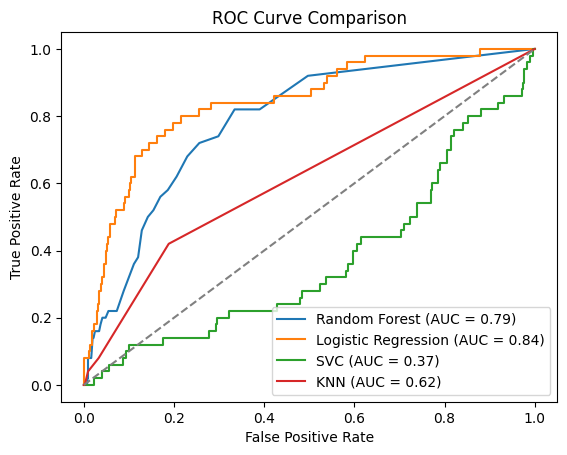

In [374]:
compare_models(X_train_classic, y_train_classic, X_test_classic, y_test_classic)

### df_nonsmoking

Confusion Matrix for Random Forest:
[[966   6]
 [ 49   1]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.14      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.55      0.51      0.50      1022
weighted avg       0.91      0.95      0.93      1022

Confusion Matrix for Logistic Regression:
[[971   1]
 [ 50   0]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Confusion Matrix for SVC:
[[972   0]
 [ 50   0]]
Classification Report for SVC:
              precision    recall  f1-score   support


c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\acull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

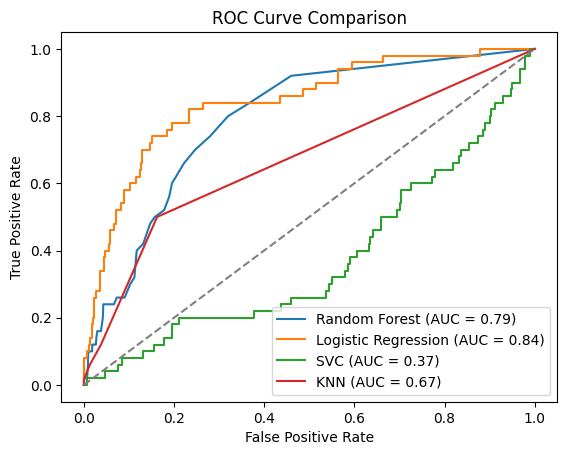

In [375]:
compare_models(X_train_nosmoking, y_train_nosmoking, X_test_nosmoking, y_test_nosmoking)

### df_upsampled

Confusion Matrix for Random Forest:
[[950  23]
 [  0 972]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       973
           1       0.98      1.00      0.99       972

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945

Confusion Matrix for Logistic Regression:
[[725 248]
 [150 822]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.83      0.75      0.78       973
           1       0.77      0.85      0.81       972

    accuracy                           0.80      1945
   macro avg       0.80      0.80      0.79      1945
weighted avg       0.80      0.80      0.79      1945

Confusion Matrix for SVC:
[[713 260]
 [144 828]]
Classification Report for SVC:
              precision    recall  f1-score   support


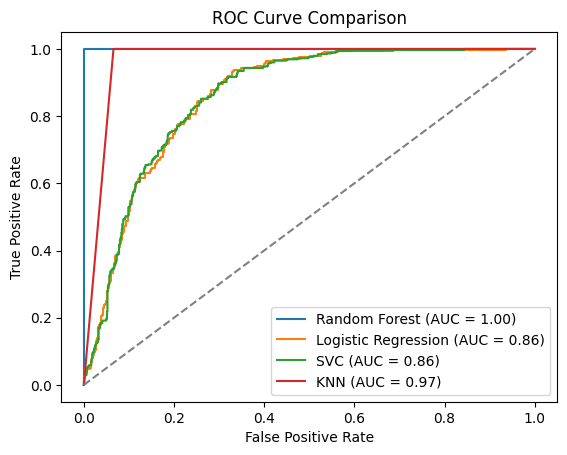

In [376]:
compare_models(X_train_upsampled, y_train_upsampled, X_test_upsampled, y_test_upsampled)

## Conclusións

O primeiro que se pode observar é que eliminar smoking_status non aparenta modificar en gran medida os resultados. 

Como estamos a falar de predecir ictuses, o importante é maximizar o recall, ainda que se den falsos positivos. Nesta área, si podemos ver que para KNN os datos sen smoking_status devolveron un valor superior de recall, 0.06, en comparativa ao mais alto do df normal, con 0.04 no KNN.

Os modelos entrenados con up-sample deron resultados moi superiores incluso tendo unha puntuación de 1 para Random Forest e KNN pero inclinome a pensar que se debe ao sobreaxuste con datos artificiais xa que os datos reais de ictus eran un 5% dos totais.